# Interacting with NSG

**This notebook aims to show how to send jobs to supercomputers through [NSG](https://www.nsgportal.org/), getting results and analysing them (based on the NeuroML2 version of the network)**

In order to be able to run the notebook install the [NeuroML](https://github.com/NeuroML/jNeuroML) toolchain, by:

    git clone git://github.com/NeuroML/jNeuroML.git neuroml_dev/jNeuroML
    cd neuroml_dev/jNeuroML
    python getNeuroML.py development

Meaning of cells and necessary installs to run them will be explained below!

authors: András Ecker, Padraig Gleeson, last modified 09.2017

In [10]:
# basic includes...
%autoreload 2
%matplotlib inline

ERROR:root:Line magic function `%autoreload` not found.


In order to accelerate the simulation we downscale the size of the network! *(but not the volume as in the original NEURON version)*

In [8]:
# important parameters used trough the whole notebook
scale = 5000 # downscaling factor
duration = 200 # ms (simulation time)

### Generating NeuroML2 network

The cells below generate a new NeuroML network, which later will be used to generate a simulation and sent to NSG.
You can skip this part, by using the default network with scale=100000, or by going to the ../NeuroML2/network folder and running

    python GenerateHippocampalNetwork_oc.py <scale>

> further (python) packages necessary to run the code below: [pyNeuroML](https://github.com/NeuroML/pyNeuroML), [OpenCortex](https://github.com/OpenSourceBrain/OpenCortex) 

In [7]:
# change directory for new network generation
%cd ../NeuroML2/network

[Errno 2] No such file or directory: '../NeuroML2/network'
/home/bandi/workspace/ca1/NeuroML2/network


In [9]:
from GenerateHippocampalNet_oc import generate_hippocampal_net

networkID = "HippocampalNet_scale%i_oc"%scale

# generate network (this might take some time)
nml_doc, network, dPops = generate_hippocampal_net(networkID=networkID,
                                                   scale=scale,
                                                   duration=duration)

GenerateHippocampalNet_oc.py:259: UserWarning: ***** Scaling down more then 1000x alters both population size and the connectivity seriously! *****
  warnings.warn("***** Scaling down more then 1000x alters both population size and the connectivity seriously! *****")


OpenCortex >>> Created NeuroMLDocument containing a network with id: HippocampalNet_scale5000_oc
Cell numbers read from config. file!
Populations created; #cells:70 (without stimulating 'cells')
OpenCortex >>> Adding projection: proj_pop_cck_pop_bistratified: <neuroml.nml.nml.Cell object at 0x7fc2debcd050> ({'soma_group': [0, 2]}) -> <neuroml.nml.nml.Cell object at 0x7fc2dec20590> ({'soma_group': [0, 2]})
OpenCortex >>> Adding convergent projection with {'soma_group': 12} conns: [<neuroml.nml.nml.Projection object at 0x7fc2de84ea90>]: pop_cck -> pop_bistratified, ['syn_cck_to_bistratified']
OpenCortex >>> Adding projection: proj_pop_ca3_pop_poolosyn: Undetermined (None) -> <neuroml.nml.nml.Cell object at 0x7fc2deb54a10> ({'dendrite_list_50_to_200': [543, 544, 545, 546, 547, 537, 538, 539, 540, 541, 542, 535, 536, 533, 534, 550, 551, 552, 553, 554, 555, 556, 597, 598, 599, 588, 589, 590, 591, 592, 593, 594, 566, 567, 568, 569, 562, 563, 564, 565, 584, 585, 586, 579, 580, 581, 582, 623, 

In [11]:
from GenerateHippocampalNet_oc import generate_lems

# generating LEMS simulation
lems_fName = generate_lems(nml_doc, network, dPops, duration=duration)

pyNeuroML >>> Creating LEMS file at: ./LEMS_HippocampalNet_scale5000_oc.xml for NeuroML 2 file: HippocampalNet_scale5000_oc.net.nml (copy: True)
pyNeuroML >>> Loading NeuroML2 file: HippocampalNet_scale5000_oc.net.nml
pyNeuroML >>> Including included files (included already: [])
pyNeuroML >>> Loading included NeuroML2 file: ../cells/axoaxonic.cell.nml (base: /home/bandi/workspace/ca1/NeuroML2/network, resolved: /home/bandi/workspace/ca1/NeuroML2/cells/axoaxonic.cell.nml, checking False)
pyNeuroML >>> Loading NeuroML2 file: /home/bandi/workspace/ca1/NeuroML2/cells/axoaxonic.cell.nml
pyNeuroML >>> Including included files (included already: [])
pyNeuroML >>> Loading included NeuroML2 file: ../channels/CavL.channel.nml (base: /home/bandi/workspace/ca1/NeuroML2/cells, resolved: /home/bandi/workspace/ca1/NeuroML2/channels/CavL.channel.nml, checking False)
pyNeuroML >>> Loading NeuroML2 file: /home/bandi/workspace/ca1/NeuroML2/channels/CavL.channel.nml
pyNeuroML >>> Including included files 

In [15]:
# go back to main 'NSG' directory
%cd ../../NSG

[Errno 2] No such file or directory: '../../NSG'
/home/bandi/workspace/ca1/NSG


### Submit jobs to NSG-R

The block of cells below, will guid through submitting jobs the NSG's REST API, but first youl'll have to get an account!

**Sign up to the NSG REST server**

1. Go to https://nsgr.sdsc.edu:8443/restusers/login.action and register for a new account
2. Log in to the service
3. Go to Developer -> Application Management
4. Click Create New Application
5. Create the application, describing what you'll be using the service for. **Please take the time to add relevant info here. Having access to this information will help the developers justify the resource and keep it free for the community!**
6. Make sure to set Authentication Type to DIRECT.
7. Make a note of the Application ID
8. Copy the [nsgrest_example.conf](https://github.com/mbezaire/ca1/blob/development/NSG/nsgrest_example.conf) file to **nsgrest.conf** and move it to your home folder
9. Update the details there with the information you entered on the NSG REST server:

    ```
    URL=https://nsgr.sdsc.edu:8443/cipresrest/v1
    USERNAME=uuuuuu
    PASSWORD=xxxxxx
    DIRECT_APPID=Direct111111111111
   ```
   
> `DIRECT_APPID` should be set to your Application ID

The simulation is parallelized under the hood with NetPyNE.

> In order to convert LEMS to NetPyNE you'll have to get [NetPyNE](https://github.com/Neurosim-lab/netpyne). If you've skipped the previous part, please install [pyNeuroML](https://github.com/NeuroML/pyNeuroML) now!

In [1]:
# one more chance to set scale
try:
    scale
except:
    scale = 5000

In [2]:
from zip_nml_forNSG import create_folder

format_ = "hdf5" if scale < 2000 else "xml"  # see saving in GenerateHippocampalNet_oc
zipName = "CA1_nml_scale%s"%scale
networkName = "HippocampalNet_scale%s_oc"%scale

# move necessary files to a subfolder (in the NSG preferred way), which will be zipped later
mainDirName = create_folder(scale, format_, zipName, networkName, copysyn=False)
print("Directory created with NeuroML2 version - scale:%s"%scale)

Directory created with NeuroML2 version - scale:5000


In [3]:
import os
import shutil
from pyneuroml import pynml

max_JAVA_memory = "8G"  # JAVA heap memory used by jnml to generate the NetPyNE simulation 

# generate NetPyNE simulation (this might take some time)
pynml.run_jneuroml("", "LEMS_%s%s.xml"%(networkName, "_h5" if format_=="hdf5" else ""), "-netpyne",
                   max_memory=max_JAVA_memory, exec_in_dir=os.path.join(mainDirName, "network"), verbose=True)  # increase heap size if necessary!


# move generated .mod files into root (for NSG)                            
for file_ in os.listdir(os.path.join(mainDirName, "network")):
    if file_.endswith(".mod"): shutil.move(os.path.join(mainDirName, "network", file_), os.path.join(mainDirName, file_))

pyNeuroML >>> Executing: (java -Xmx8G  -jar  "/usr/local/lib/python2.7/dist-packages/pyNeuroML-0.3.1-py2.7.egg/pyneuroml/lib/jNeuroML-0.8.3-jar-with-dependencies.jar"  "LEMS_HippocampalNet_scale5000_oc.xml" -netpyne) in directory: /home/bandi/workspace/ca1/NSG/CA1_nml/network
pyNeuroML >>> Command completed. Output: 
pyNeuroML >>>   jNeuroML >>   jNeuroML v0.8.3
pyNeuroML >>>   jNeuroML >>  (INFO) Reading from: /home/bandi/workspace/ca1/NSG/CA1_nml/network/LEMS_HippocampalNet_scale5000_oc.xml
pyNeuroML >>>   jNeuroML >>  (WARNING) Unused attribute in Component(id=fixedCapool type=FixedCaConcentrationModel): XMLAttribute(ion, ca)  at: org.lemsml.jlems.core.type.Component.resolve(Component.java:539)
pyNeuroML >>>   jNeuroML >>  (WARNING) Unused attribute in Component(id=Sim_HippocampalNet_scale5000_oc type=Simulation): XMLAttribute(seed, 12345)  at: 
pyNeuroML >>>   jNeuroML >>  (INFO) Creating NeuronWriter for ---
pyNeuroML >>>   jNeuroML >>  (INFO) -- Writing to hoc: /home/bandi/worksp

In [4]:
from zip_nml_forNSG import create_init, create_zip

# zips the subfolder, with all the necessary files inside!
create_init(mainDirName, format_, networkName)
create_zip(zipName, mainDirName, rm=False)

zip file created: /home/bandi/workspace/ca1/NSG/CA1_nml.zip


Python could be used to interact with NSG, but we're going to use `curl` commands in shell scripts, called from here.
(It'll use CA1_nml.zip created above. If you've changed the `zip_name` above you'll have to change `submit_nml_toNSG.sh`)
> Note: make sure, you've set up everything and put `nsgrest.conf` to your home directory

In [2]:
jobID = "Test_nml"
numNodes = 2  # number of nodes to use, each with 24 cores
runHours = 1  # allocated time for the whole simulation

!./submit_nml_toNSG.sh $scale $jobID $numNodes $runHours

Read in data for NSG REST API user: andrisecker to access: https://nsgr.sdsc.edu:8443/cipresrest/v1...
Accessing: https://nsgr.sdsc.edu:8443/cipresrest/v1/job/andrisecker for user andrisecker
HTTP/1.1 100 Continue

HTTP/1.1 200 OK
Server: Apache-Coyote/1.1
Content-Type: application/xml
Transfer-Encoding: chunked
Date: Sun, 17 Sep 2017 17:44:26 GMT

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<jobstatus>
    <selfUri>
        <url>https://nsgr.sdsc.edu:8443/cipresrest/v1/job/andrisecker/NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2</url>
        <rel>jobstatus</rel>
        <title>NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2</title>
    </selfUri>
    <jobHandle>NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2</jobHandle>
    <jobStage>QUEUE</jobStage>
    <terminalStage>false</terminalStage>
    <failed>false</failed>
    <metadata>
        <entry>
            <key>statusEmail</key>
            <value>true</value>
        </entry>
        <entry>

If you want, you can list your current jobs:

In [11]:
!./list_jobs.sh

### Downloading results

**You'll have to wait until the job is finished and then return to the notebook...**

After the task is finished you'll get an e-mail, with the name of the NSG job... Copy that into `jobName` and run the cells bellow.
> Note: the name should look like: NGBW-JOB-OSBPYNEURON74-<randomID>

In [7]:
jobName = "NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2"  #jobName from the e-mail

# list the results produced by NSG:
!./list_results.sh $jobName

Read in data for NSG REST API user: andrisecker to access: https://nsgr.sdsc.edu:8443/cipresrest/v1...
Accessing: https://nsgr.sdsc.edu:8443/cipresrest/v1/job/andrisecker/NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2 for user andrisecker
HTTP/1.1 200 OK
Server: Apache-Coyote/1.1
Cache-Control: private
Expires: Wed, 31 Dec 1969 16:00:00 PST
Content-Type: application/xml
Transfer-Encoding: chunked
Date: Sun, 17 Sep 2017 17:55:08 GMT

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<results>
    <jobfiles>
        <jobfile>
            <downloadUri>
                <url>https://nsgr.sdsc.edu:8443/cipresrest/v1/job/andrisecker/NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2/output/1717</url>
                <rel>fileDownload</rel>
                <title>STDOUT</title>
            </downloadUri>
            <jobHandle>NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2</jobHandle>
            <filename>STDOUT</filename>
            <length>81752</length>
      

**look for output.tar.gz** (line with: `<filename>output.tar.gz</filename>`), set `outputDocumentId` with the ID of output.tar.gz (or any other document which you want to download separately) and download the results
> Note: you might have to delete the current output.tar.gz first

In [8]:
outputDocumentId = 1721

# download the results
!./download_results.sh $jobName $outputDocumentId

Read in data for NSG REST API user: andrisecker to access: https://nsgr.sdsc.edu:8443/cipresrest/v1...
Accessing: https://nsgr.sdsc.edu:8443/cipresrest/v1/job/andrisecker/NGBW-JOB-OSBPYNEURON74-0FCC245C86734CF7A4CBD7A80A607EB2 for user andrisecker
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.3M    0 24.3M    0     0   644k      0 --:--:--  0:00:38 --:--:-- 1417k
curl: Saved to filename 'output.tar.gz'


### Analysing results

One you have succesfully downloaded the results, you can **analyse** and **visualize** them by running the following boxes below

In [6]:
from analyse_nml_results import *

# extract necessary files into a separate directory
tarName = "output.tar.gz"
scale, resultDir = extract_tar(tarName)
resultDir = os.path.join(NSGbasePath, "results_nml_scale%s"%scale)
print("scale = %s"%scale)

# get some runspecific data from configg files
simduration, dt = get_simduration_dt(resultDir)
dPops = get_popsize(resultDir, scale)

results moved to: /home/bandi/workspace/ca1/NSG/results_nml_scale750
scale = 750
>>> NetPyNE based simulation for 500.0ms (dt: 0.01ms)


**Load** in traces and spikes (to python dictionaries) and anaylse PC rate - same method as in eLife paper with the NEURON version

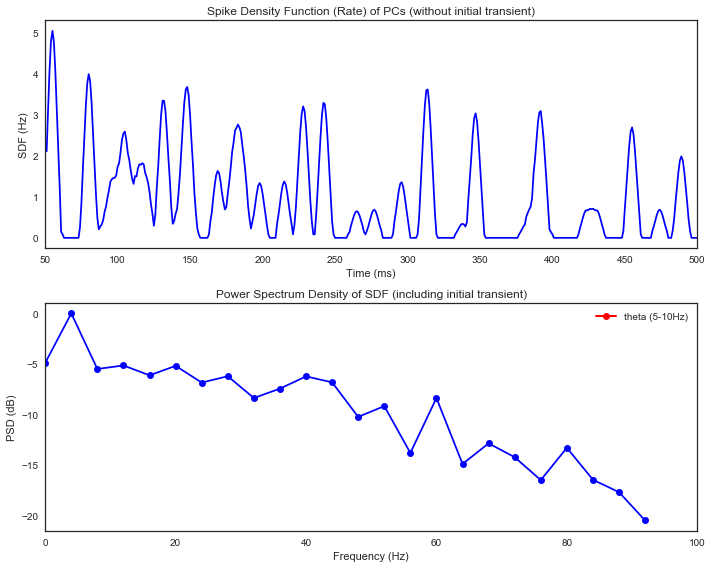

In [8]:
import os
import sys
%matplotlib inline
from analyse_nrn_results import analyse_rate  # PSD analysis of SDF (rate)
from plots import plot_traces, plot_rasters  # Fig3 like plots
basePath = os.path.sep.join(os.path.abspath('__file__').split(os.path.sep)[:-2])
# add the 'network' directory to the path (import the modules)
sys.path.insert(0, os.path.sep.join([basePath, "NeuroML2", "network"]))
from analyse_PING import get_traces, get_spikes_rate  # functions to process NetPyNE output

# load in traces and spikes
dTraces = {}; dSpikeTimes = {}; dSpikingNeurons = {}; dRates = {}; dPlotTraces = {}; dIDx = {} # dIDx used only for setting ylim of rasters...
for cell_type, ncells in dPops.iteritems():
    fName = os.path.join(resultDir, "Sim_HippocampalNet_scale%s_oc.%scell.v.dat"%(scale, cell_type))
    t, traces = get_traces(fName, simduration, dt)
    dPlotTraces[cell_type] = traces[0, :]; dIDx[cell_type] = [0, dPops[cell_type]-1] if dPops[cell_type] != 1 else [-1e-3, 1.e-3]  # for NEURON version's Fig3 plot
        
    fName = os.path.join(resultDir, "Sim_HippocampalNet_scale%s_oc.pop_%s.spikes"%(scale, cell_type))
    spikeTimes, spikingNeurons, rate = get_spikes_rate(fName, t, dPops[cell_type])
    dSpikeTimes[cell_type] = spikeTimes; dSpikingNeurons[cell_type] = spikingNeurons; dRates[cell_type] = rate
    
    # analyse PC rate (same way as in the original article)
    if cell_type == "poolosyn" and rate.any():
        analyse_rate(rate, "nml_scale%s"%scale)

**Plot** spike raster and selected (the first one saved) traces for every population

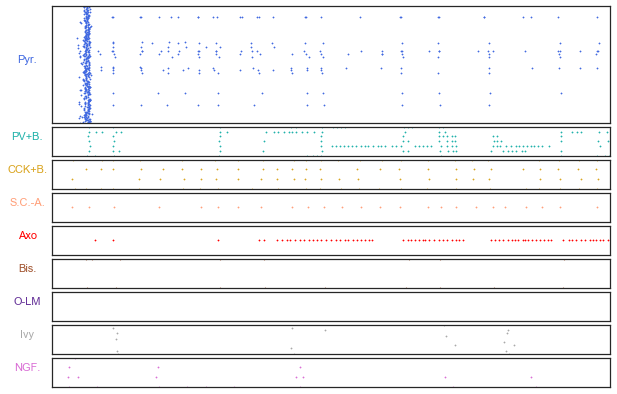

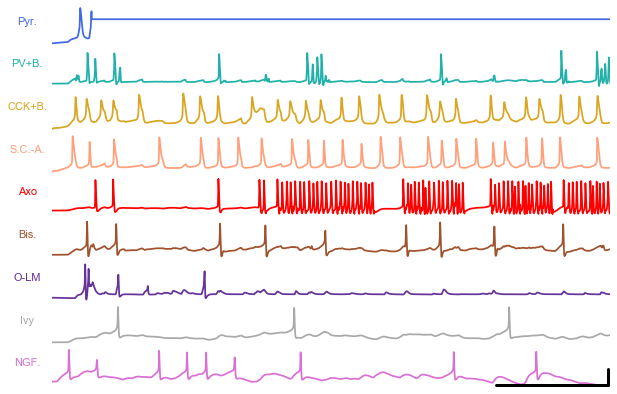

In [10]:
# plot results (see plots.py)
plot_rasters(dSpikeTimes, dSpikingNeurons, dIDx, simduration, "nml_scale%s"%scale)
plot_traces(dPlotTraces, t, "nml_scale%s"%scale)